# Task 2--Tell The Time

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
import numpy as np
from keras.initializers import HeNormal, HeUniform
from keras.optimizers import SGD,Adam,RMSprop,Adagrad,Nadam
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

## Load data 

In [2]:
x_data  = np.load("/kaggle/input/clock-large/images.npy")
y_data  = np.load("/kaggle/input/clock-large/labels.npy")
print(x_data.shape)

(18000, 150, 150)


In [3]:
row_cnt=x_data.shape[1]
colomn_cnt=x_data.shape[2]
if K.image_data_format() == 'channel_first':
    x_data=x_data.reshape(x_data.shape[0],1,row_cnt,colomn_cnt)
    input_shape=(1,row_cnt,colomn_cnt)
else:
    x_data= x_data.reshape(x_data.shape[0],row_cnt,colomn_cnt,1)
    input_shape=(row_cnt,colomn_cnt,1)

print(input_shape,x_data.shape)

(150, 150, 1) (18000, 150, 150, 1)


In [4]:
(x_train,x_test,y_train,y_test)= train_test_split(x_data,y_data,test_size=0.2)
(x_validate,x_train) = (x_train[:1800],x_train[1800:])
(y_validate,y_train) = (y_train[:1800],y_train[1800:])

print(x_train.shape,x_validate.shape,x_test.shape,y_train.shape,y_validate.shape,y_test.shape)

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_validate = x_validate.astype('float32')/255

(12600, 150, 150, 1) (1800, 150, 150, 1) (3600, 150, 150, 1) (12600, 2) (1800, 2) (3600, 2)


## Classification Model

Dividing the total 720 minutes into n regions to treat the telling-clock problem as an n-class classification problem.

**Process labels**

In [5]:
def processing_c_labels(categories):
    catergory_range= 720/categories
    y_train_class= ((y_train[:,0]*60+ y_train[:,1])/catergory_range).astype(np.int32) 
    y_test_class= ((y_test[:,0]*60+ y_test[:,1])/catergory_range).astype(np.int32) 
    y_validate_class= ((y_validate[:,0]*60+ y_validate[:,1])/catergory_range).astype(np.int32) 
    return (y_train_class,y_test_class,y_validate_class)

**Build the model**

In [6]:
def build_model_task2_c1(categories,input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32,kernel_size=(7,7),activation='relu',padding='same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x= Dropout(0.2)(x)

    x = Conv2D(32,kernel_size=(5,5),activation='relu',padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x= Dropout(0.2)(x)

    x = Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    #x = Dropout(0.1)(x)

    x = Conv2D(64,kernel_size=(3,3),activation='relu', padding='same', dilation_rate=2, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    # #x= Dropout(0.2)(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    #x= Dropout(0.2)(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x= Flatten()(x)
    x= Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x= Dropout(0.4)(x)
 
    output= Dense(categories, activation='softmax')(x)   
    model = Model(inputs=[inputs], outputs=[output])

    # Define the learning rate scheduler
    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=200,
        decay_rate=0.96,
        staircase=True
    )

    # Set up the optimizer with the learning rate schedule
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    #opt = Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


**Train & Evaluate the model**

In [7]:
def plot_training_history(history, accuracy_title='Model Accuracy', loss_title='Model Loss'):

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(accuracy_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(loss_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig(f'{accuracy_title}.png')
    plt.show()



def evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold):
    # category_range = 720 / classnum  
    # y_test_time = y_test_class * category_range  
    # y_pred_time = y_pred_class * category_range 
    # time_diff = np.abs(y_pred_time - y_test_time)
    # time_diff = np.minimum(time_diff, 720 - time_diff)
    time_diff = np.abs(y_pred_class - y_test_class)
    time_diff = np.minimum(time_diff, classnum - time_diff)

    # Calculate metrics
    mean_error = np.mean(time_diff)
    max_time_diff = np.max(time_diff)
    median_error = np.median(time_diff)
    std_dev_error = np.std(time_diff)
    percentage_within_threshold = np.mean(time_diff <= threshold) * 100
    predict_accuracy = np.mean(time_diff <= 0) * 100

    error_metrics = {
        'Mean Error (Time Zone)': mean_error,
        'Max Time Difference (Time Zone)': max_time_diff,
        'Median Error (Time Zone)': median_error,
        'Standard Deviation of Error (Time Zone)': std_dev_error,
        'Predict_accuracy(%)':predict_accuracy,
        f'Percentage within {threshold} Time Zone': percentage_within_threshold
    }

    return error_metrics

**Try 24 categories**

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0493 - loss: 3.4044 - val_accuracy: 0.0406 - val_loss: 3.6471
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0637 - loss: 3.0541 - val_accuracy: 0.0817 - val_loss: 3.1487
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1265 - loss: 2.6732 - val_accuracy: 0.0972 - val_loss: 3.9816
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2004 - loss: 2.2745 - val_accuracy: 0.2550 - val_loss: 2.1003
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2806 - loss: 1.9571 - val_accuracy: 0.2900 - val_loss: 1.9834
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4108 - loss: 1.5682 - val_accuracy: 0.2122 - val_loss: 2.8666
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5269 - loss: 1.2349 - val_accuracy: 0.2917 - val_loss: 2.3958
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6312 - loss: 0.9845 -

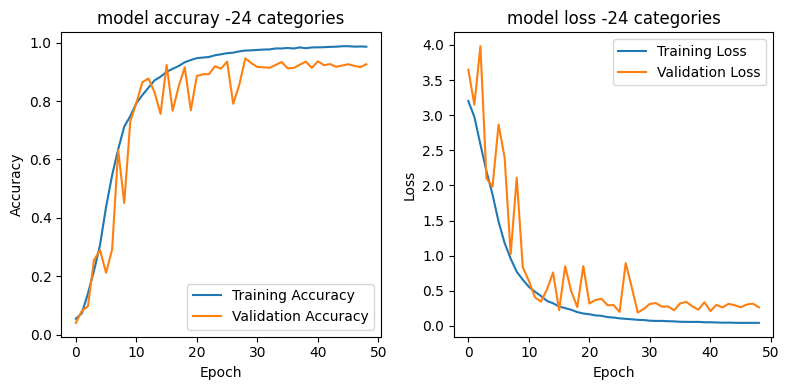

In [61]:
classnum=24
(y_train_class,y_test_class,y_validate_class) = processing_c_labels(classnum)
model_c1 = build_model_task2_c1(classnum,input_shape)

#from tensorflow.keras.utils import plot_model
#plot_model(model_c1, to_file='model_cl.png', show_shapes=True, show_layer_names=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history_c1 = model_c1.fit(x_train,y_train_class,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_class),callbacks=[early_stopping_cb])
plot_training_history(history_c1,f'model accuray -{classnum} categories',f'model loss -{classnum} categories')

In [62]:
#keras.utils.plot_model(model_c1, to_file='model.png', show_shapes=True)
classnum=24
loss, accuracy = model_c1.evaluate(x_test, y_test_class)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

y_pred_class = np.argmax(model_c1.predict(x_test), axis=1)
error_metrics = evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold=1)

# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9319 - loss: 0.2252
Test loss: 0.21448898315429688
Test accuracy: 0.9338889122009277
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Mean Error (Time Zone): 0.10416666666666667
Max Time Difference (Time Zone): 11
Median Error (Time Zone): 0.0
Standard Deviation of Error (Time Zone): 0.4666480651054568
Predict_accuracy(%): 93.38888888888889
Percentage within 1 Time Zone: 97.11111111111111


**Try 36 categories**

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0313 - loss: 3.8121 - val_accuracy: 0.0328 - val_loss: 3.7052
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0372 - loss: 3.5346 - val_accuracy: 0.0261 - val_loss: 7.2580
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0894 - loss: 3.1316 - val_accuracy: 0.0500 - val_loss: 6.1718
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2002 - loss: 2.3609 - val_accuracy: 0.0922 - val_loss: 4.6329
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2832 - loss: 1.9709 - val_accuracy: 0.1633 - val_loss: 3.7047
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3506 - loss: 1.7214 - val_accuracy: 0.3150 - val_loss: 2.3927
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4303 - loss: 1.4778 - val_accuracy: 0.3572 - val_loss: 1.9976
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5291 - loss: 1.2429 -

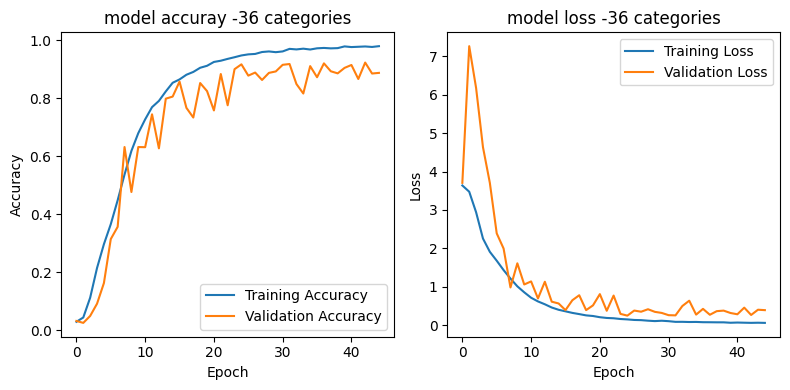

In [10]:
classnum=36
(y_train_class,y_test_class,y_validate_class) = processing_c_labels(classnum)
model_c2 = build_model_task2_c1(classnum,input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history_c2 = model_c2.fit(x_train,y_train_class,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_class),callbacks=[early_stopping_cb])
plot_training_history(history_c2,f'model accuray -{classnum} categories',f'model loss -{classnum} categories')

In [11]:
loss, accuracy = model_c2.evaluate(x_test, y_test_class)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")
y_pred_class = np.argmax(model_c2.predict(x_test), axis=1)
error_metrics = evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold=1)

# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9291 - loss: 0.2359
Test loss: 0.255964994430542
Test accuracy: 0.9202777743339539
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Error (Time Zone): 0.16694444444444445
Max Time Difference (Time Zone): 16
Median Error (Time Zone): 0.0
Standard Deviation of Error (Time Zone): 0.787870968864983
Predict_accuracy(%): 92.02777777777777
Percentage within 1 Time Zone: 96.41666666666666


**Try 48 categories**

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0203 - loss: 4.0670 - val_accuracy: 0.0222 - val_loss: 3.9492
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0221 - loss: 3.8723 - val_accuracy: 0.0250 - val_loss: 3.8726
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0219 - loss: 3.8713 - val_accuracy: 0.0294 - val_loss: 3.8650
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0301 - loss: 3.8244 - val_accuracy: 0.0383 - val_loss: 3.6835
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0361 - loss: 3.7318 - val_accuracy: 0.0483 - val_loss: 3.6059
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0567 - loss: 3.4779 - val_accuracy: 0.1122 - val_loss: 2.9664
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1473 - loss: 2.6979 - val_accuracy: 0.1033 - val_loss: 3.0493
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2335 - loss: 2.2536 -

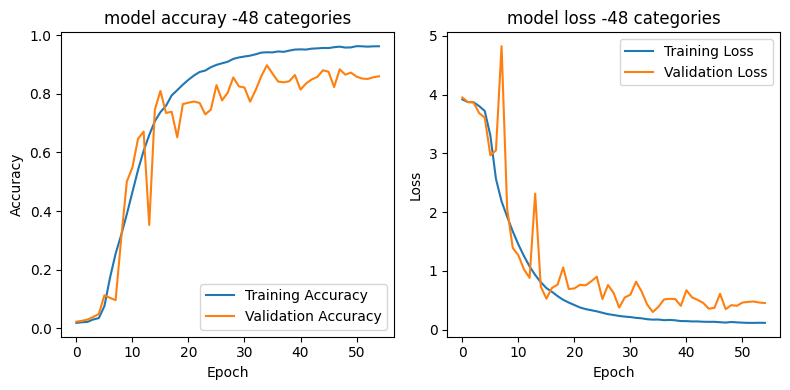

In [12]:
classnum=48

(y_train_class,y_test_class,y_validate_class) = processing_c_labels(classnum)
model_c3 = build_model_task2_c1(classnum,input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history_c3 = model_c3.fit(x_train,y_train_class,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_class),callbacks=[early_stopping_cb])
plot_training_history(history_c3,f'model accuray -{classnum} categories',f'model loss -{classnum} categories')

In [13]:
loss, accuracy = model_c3.evaluate(x_test, y_test_class)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

y_pred_class = np.argmax(model_c3.predict(x_test), axis=1)
error_metrics = evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold=1)

# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9033 - loss: 0.2831
Test loss: 0.2906493842601776
Test accuracy: 0.9019444584846497
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Error (Time Zone): 0.27555555555555555
Max Time Difference (Time Zone): 18
Median Error (Time Zone): 0.0
Standard Deviation of Error (Time Zone): 1.1468130828141
Predict_accuracy(%): 90.19444444444444
Percentage within 1 Time Zone: 95.16666666666667


**Try 72 categories**

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0144 - loss: 4.4709 - val_accuracy: 0.0144 - val_loss: 4.3943
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0186 - loss: 4.2389 - val_accuracy: 0.0178 - val_loss: 4.2161
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0185 - loss: 4.1683 - val_accuracy: 0.0261 - val_loss: 4.0738
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0357 - loss: 3.9395 - val_accuracy: 0.0961 - val_loss: 3.3144
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.0942 - loss: 3.2366 - val_accuracy: 0.1672 - val_loss: 2.5331
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1731 - loss: 2.5973 - val_accuracy: 0.3667 - val_loss: 1.8375
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2584 - loss: 2.2172 - val_accuracy: 0.1217 - val_loss: 3.3291
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3245 - loss: 1.9022 -

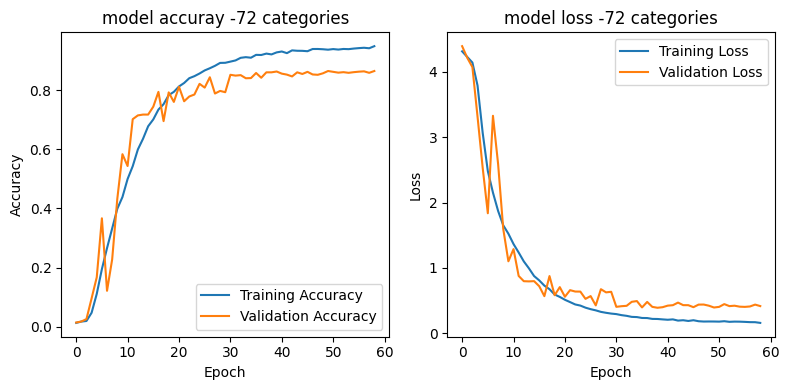

In [59]:
classnum=72
(y_train_class,y_test_class,y_validate_class) = processing_c_labels(classnum)
model_c4 = build_model_task2_c1(classnum,input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history_c4 = model_c4.fit(x_train,y_train_class,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_class),callbacks=[early_stopping_cb])
plot_training_history(history_c4,f'model accuray -{classnum} categories',f'model loss -{classnum} categories')

In [60]:
loss, accuracy = model_c4.evaluate(x_test, y_test_class)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

y_pred_class = np.argmax(model_c4.predict(x_test), axis=1)
error_metrics = evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold=1)

# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8666 - loss: 0.3700
Test loss: 0.37564873695373535
Test accuracy: 0.8650000095367432
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Error (Time Zone): 0.6411111111111111
Max Time Difference (Time Zone): 33
Median Error (Time Zone): 0.0
Standard Deviation of Error (Time Zone): 2.6487059500587344
Predict_accuracy(%): 86.5
Percentage within 1 Time Zone: 93.38888888888889


**Try 120 categories**

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.0083 - loss: 4.9715 - val_accuracy: 0.0072 - val_loss: 4.8115
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0083 - loss: 4.7875 - val_accuracy: 0.0078 - val_loss: 4.7919
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0087 - loss: 4.7869 - val_accuracy: 0.0078 - val_loss: 4.7918
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0067 - loss: 4.7879 - val_accuracy: 0.0067 - val_loss: 4.7919
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0096 - loss: 4.7865 - val_accuracy: 0.0083 - val_loss: 4.7930
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0086 - loss: 4.7868 - val_accuracy: 0.0072 - val_loss: 4.7934
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0072 - loss: 4.7858 - val_accuracy: 0.0067 - val_loss: 4.7939
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.0085 - loss: 4.7865 -

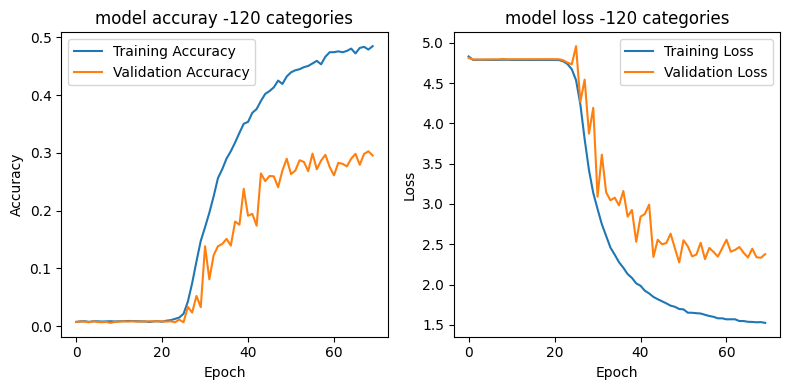

In [16]:
classnum=120
(y_train_class,y_test_class,y_validate_class) = processing_c_labels(classnum)

model_c5 = build_model_task2_c1(classnum,input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history_c5 = model_c5.fit(x_train,y_train_class,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_class),callbacks=[early_stopping_cb])
plot_training_history(history_c5,f'model accuray -{classnum} categories',f'model loss -{classnum} categories')

In [17]:
classnum=120
loss, accuracy = model_c5.evaluate(x_test, y_test_class)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

y_pred_class = np.argmax(model_c5.predict(x_test), axis=1)
error_metrics = evaluate_time_error_metrics(y_test_class, y_pred_class, classnum, threshold=1)
# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2865 - loss: 2.2440
Test loss: 2.275376558303833
Test accuracy: 0.28305554389953613
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Error (Time Zone): 14.13888888888889
Max Time Difference (Time Zone): 60
Median Error (Time Zone): 10.0
Standard Deviation of Error (Time Zone): 16.65363286656461
Predict_accuracy(%): 28.305555555555557
Percentage within 1 Time Zone: 39.83333333333333


## Regression Model

**Process labels**

In [18]:
y_train_sreg= (y_train[:,0] + y_train[:,1]/60).astype('float32')
y_test_sreg=  (y_test[:,0] + y_test[:,1]/60).astype('float32')
y_validate_sreg=  (y_validate[:,0] + y_validate[:,1]/60).astype('float32')

**Build the regression model**|

In [19]:
def build_model_task2_r1(input_shape):
    inputs = Input(shape=input_shape)  
    x = Conv2D(32,kernel_size=(7,7),activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32,kernel_size=(5,5),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)


    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', dilation_rate=2, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x= Flatten()(x)
    x= Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x= Dropout(0.2)(x)

    output=Dense(1, activation='linear')(x)   
    model = Model(inputs=[inputs], outputs=[output])

    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=200,
        decay_rate=0.96,
        staircase=True
    )
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
    return model

**Train the model**

In [20]:
def plot_regression_loss(history, loss_title='Regression Model Loss'):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(loss_title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.savefig("regression model loss.png")
    plt.show()



def plot_predicted_vs_true(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Line y=x for reference
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs True Values in Regression Model')
    plt.savefig("true vs predict-regression.png")
    plt.show()

Epoch 1/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 15.9422 - mae: 3.0260 - val_loss: 16.9982 - val_mae: 3.3620
Epoch 2/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 6.9217 - mae: 2.0486 - val_loss: 6.5421 - val_mae: 1.8501
Epoch 3/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4.7277 - mae: 1.6228 - val_loss: 4.9527 - val_mae: 1.5683
Epoch 4/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 2.7079 - mae: 1.2186 - val_loss: 3.1892 - val_mae: 1.2979
Epoch 5/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.7349 - mae: 0.9758 - val_loss: 2.2731 - val_mae: 1.0277
Epoch 6/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.2849 - mae: 0.8373 - val_loss: 1.4390 - val_mae: 0.7483
Epoch 7/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.0688 - mae: 0.7614 - val_loss: 1.7789 - val_mae: 0.8621
Epoch 8/100
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7423 - mae: 0.6494 - val_loss: 1.6298 - val_mae: 0.7397
Epoch 9/100
394/394 ━━━━━━━━━━━━━━━━━

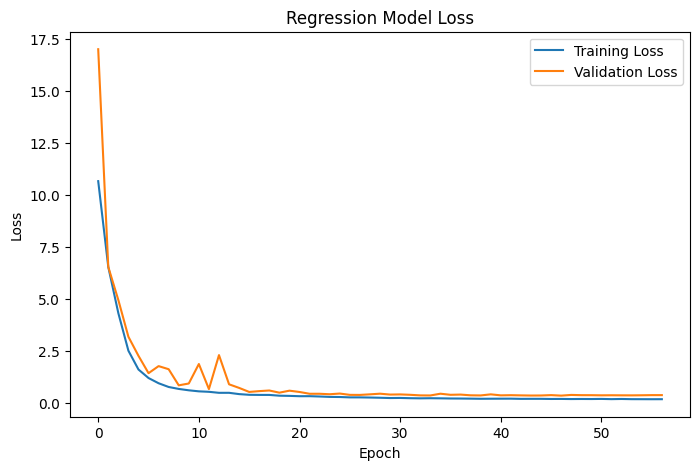

In [21]:
model_r = build_model_task2_r1(input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
history_r = model_r.fit(x_train,y_train_sreg,epochs=100,batch_size=32,verbose=1,validation_data=(x_validate,y_validate_sreg),callbacks=[early_stopping_cb])

plot_regression_loss(history_r)

In [22]:
def calculate_common_sense_error_r(y_true, y_pred, threshold=10):
    y_true_minutes = (y_true * 60).astype(np.int32)
    y_pred_minutes = (y_pred * 60).astype(np.int32)

    time_diff = np.abs(y_pred_minutes - y_true_minutes)
    time_diff = np.minimum(time_diff, 720 - time_diff)

    mean_error = np.mean(time_diff)
    max_error = np.max(time_diff)
    median_error = np.median(time_diff)
    std_dev_error = np.std(time_diff)

    percentage_within_threshold = np.mean(time_diff <= threshold) * 100
    predict_accuracy =  np.mean(time_diff <= 0) * 100
    error_metrics = {
        'Mean Common Sense Error (minutes)': mean_error,
        'Max Common Sense Error (minutes)': max_error,
        'Median Common Sense Error (minutes)': median_error,
        'Standard Deviation of Error (minutes)': std_dev_error,
        'Predict Accuracy (%)': predict_accuracy,
        f'Percentage within {threshold} minutes': percentage_within_threshold
    }

    return error_metrics

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


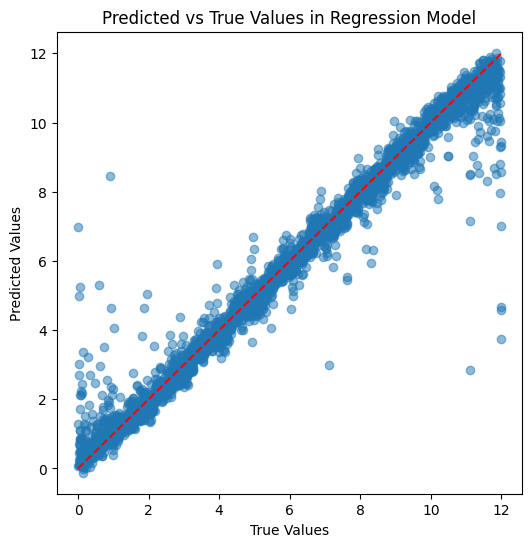

Mean Common Sense Error (minutes): 16.644444444444446
Max Common Sense Error (minutes): 310
Median Common Sense Error (minutes): 10.0
Standard Deviation of Error (minutes): 25.85568328288176
Predict Accuracy (%): 2.3333333333333335
Percentage within 10 minutes: 50.69444444444444


In [23]:
y_predict = model_r.predict(x_test)
plot_predicted_vs_true(y_test_sreg,y_predict)

error_metrics = calculate_common_sense_error_r(y_test_sreg.reshape(-1,1), y_predict,10)
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

## Multi-head Model

**Process labels**

In [63]:
y_train_mreg= (y_train[:,1]/60).astype('float32')
y_test_mreg=  (y_test[:,1]/60).astype('float32')
y_validate_mreg=  (y_validate[:,1]/60).astype('float32')

y_train_mclass= y_train[:,0]
y_test_mclass= y_test[:,0]
y_validate_mclass= y_validate[:,0]

**Build the multi head model**

In [91]:
def build_model_task2_rc(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32,kernel_size=(7,7),activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32,kernel_size=(5,5),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', dilation_rate=2, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x= Flatten()(x)
    x= Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x= Dropout(0.5)(x)


    hour_output= Dense(12, activation='softmax', name='hour_output')(x)
    minute_output = Dense(1, activation='linear', name='minute_output')(x)

    model = Model(inputs=[inputs],outputs=[hour_output,minute_output])

    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=200,
        decay_rate=0.96,
        staircase=True
    )
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    loss_weights = {'hour_output': 10.0, 'minute_output': 1.0}
    model.compile(loss={'hour_output': 'sparse_categorical_crossentropy', 'minute_output': 'mse'},  loss_weights=loss_weights,
              optimizer=opt, metrics={'hour_output': 'accuracy', 'minute_output': 'mae'})

    return model

**Train the model**

In [26]:
def plot_multi_output_history(history):
    plt.figure(figsize=(15, 5))

    # Classification Accuracy for hour_output
    plt.subplot(1, 3, 1)
    plt.plot(history.history['hour_output_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_hour_output_accuracy'], label='Validation Accuracy')
    plt.title('Hour Prediction Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    # Combined Loss (for both hour and minute outputs)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Overall Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')


    # Regression Loss for minute_output (MAE)
    plt.subplot(1, 3, 3)
    plt.plot(history.history['minute_output_mae'], label='Training MAE')
    plt.plot(history.history['val_minute_output_mae'], label='Validation MAE')
    plt.title('Minute Prediction Error (MAE)')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig("multi_model_loss.png")
    plt.show()

Epoch 1/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - hour_output_accuracy: 0.0928 - loss: 36.3573 - minute_output_mae: 1.0934 - val_hour_output_accuracy: 0.0917 - val_loss: 24.9545 - val_minute_output_mae: 0.2821
Epoch 2/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_accuracy: 0.1209 - loss: 24.1801 - minute_output_mae: 0.3572 - val_hour_output_accuracy: 0.2178 - val_loss: 20.7301 - val_minute_output_mae: 0.3061
Epoch 3/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_accuracy: 0.2355 - loss: 19.7330 - minute_output_mae: 0.3573 - val_hour_output_accuracy: 0.3806 - val_loss: 15.6081 - val_minute_output_mae: 0.2834
Epoch 4/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_accuracy: 0.4337 - loss: 13.7483 - minute_output_mae: 0.3150 - val_hour_output_accuracy: 0.5378 - val_loss: 11.1996 - val_minute_output_mae: 0.2584
Epoch 5/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_accuracy: 0.6053 - loss: 9.3240 - minute_output_mae: 0.3083 - val_h

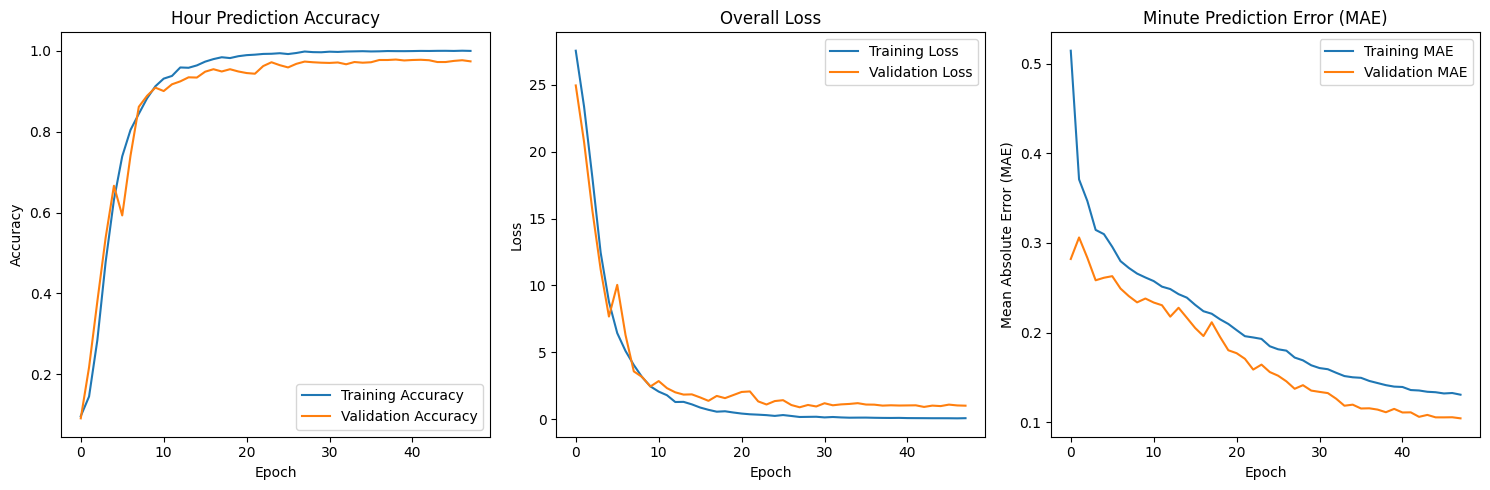

In [92]:
model_rc = build_model_task2_rc(input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

history_rc = model_rc.fit(x_train,[y_train_mclass,y_train_mreg],epochs=200,verbose=1,validation_data=(x_validate,[y_validate_mclass,y_validate_mreg]),callbacks=[#checkpoint_cb,
    early_stopping_cb])

plot_multi_output_history(history_rc)

**Evaluate the model**

In [94]:
loss, hour_accuracy, minute_mae = model_rc.evaluate(x_test, [y_test_mclass, y_test_mreg])
print(f"Test Loss (MSE): {loss}")
print(f"Test HOUR ACCURACY: {hour_accuracy}")
print(f"Test MINITE MAE: {minute_mae}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - hour_output_accuracy: 0.9683 - loss: 1.2063 - minute_output_mae: 0.1378
Test Loss (MSE): 1.2989606857299805
Test HOUR ACCURACY: 0.9672222137451172
Test MINITE MAE: 0.13883669674396515


In [29]:
def calculate_common_sense_error_rc(y_true_hours, y_true_minutes, y_pred_hours, y_pred_minutes, threshold=10):
    y_true_total_minutes = (y_true_hours * 60 + y_true_minutes).astype(np.int32)
    y_pred_total_minutes = (y_pred_hours * 60 + y_pred_minutes).astype(np.int32)

    time_diff = np.abs(y_pred_total_minutes - y_true_total_minutes)
    time_diff = np.minimum(time_diff, 720 - time_diff)

    mean_error = np.mean(time_diff)
    max_error = np.max(time_diff)
    median_error = np.median(time_diff)
    std_dev_error = np.std(time_diff)
    percentage_within_threshold = np.mean(time_diff <= threshold) * 100

    error_metrics = {
        'Mean Common Sense Error (minutes)': mean_error,
        'Max Common Sense Error (minutes)': max_error,
        'Median Common Sense Error (minutes)': median_error,
        'Standard Deviation of Error (minutes)': std_dev_error,
        f'Percentage within {threshold} minutes': percentage_within_threshold
    }

    return error_metrics


In [93]:
predictions = model_rc.predict(x_test)
y_pred_hours = np.argmax(predictions[0], axis=1) 
y_pred_minutes = predictions[1]*60

error_metrics = calculate_common_sense_error_rc(y_test_mclass, y_test_mreg *60, y_pred_hours, y_pred_minutes, threshold=10)

for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Mean Common Sense Error (minutes): 16.956635648148147
Max Common Sense Error (minutes): 128
Median Common Sense Error (minutes): 15.0
Standard Deviation of Error (minutes): 11.761338826154347
Percentage within 10 minutes: 35.05287037037037


## Label transformation - Multi-regression Model

**Process labels**

In [95]:
def hands_angle(hour, minute):
    minute_angle = minute * 6
    hour_angle = (hour % 12) * 30 + (minute * 0.5)    
    return (hour_angle, minute_angle)


vectorized_hands_angle = np.vectorize(hands_angle)

# Calculate hour and minute angles for training set
(y_train_hour_angle, y_train_minute_angle) = vectorized_hands_angle(y_train[:, 0], y_train[:, 1])
y_train_hour_x = np.cos(np.radians(y_train_hour_angle))
y_train_hour_y = np.sin(np.radians(y_train_hour_angle))
y_train_minute_x = np.cos(np.radians(y_train_minute_angle))
y_train_minute_y = np.sin(np.radians(y_train_minute_angle))


# Calculate hour and minute angles for test set
(y_test_hour_angle, y_test_minute_angle) = vectorized_hands_angle(y_test[:, 0], y_test[:, 1])
y_test_hour_x = np.cos(np.radians(y_test_hour_angle))
y_test_hour_y = np.sin(np.radians(y_test_hour_angle))
y_test_minute_x = np.cos(np.radians(y_test_minute_angle))
y_test_minute_y = np.sin(np.radians(y_test_minute_angle))


# Calculate hour and minute angles for validation set
(y_validate_hour_angle, y_validate_minute_angle) = vectorized_hands_angle(y_validate[:, 0], y_validate[:, 1])
y_validate_hour_x = np.cos(np.radians(y_validate_hour_angle))
y_validate_hour_y = np.sin(np.radians(y_validate_hour_angle))
y_validate_minute_x = np.cos(np.radians(y_validate_minute_angle))
y_validate_minute_y = np.sin(np.radians(y_validate_minute_angle))

**Build the multi regression model**

In [96]:
def build_model_task2_mr(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32,kernel_size=(7,7),activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(32,kernel_size=(5,5),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same', dilation_rate=2, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(256,kernel_size=(3,3),activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x= Flatten()(x)
    x= Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x= Dropout(0.1)(x)

    hour_output_x = Dense(1, activation='linear', name='hour_output_x')(x)
    hour_output_y = Dense(1, activation='linear', name='hour_output_y')(x)
    minute_output_x = Dense(1, activation='linear', name='minute_output_x')(x)
    minute_output_y = Dense(1, activation='linear', name='minute_output_y')(x)

    model = Model(inputs=[inputs], outputs=[hour_output_x, hour_output_y, minute_output_x, minute_output_y])

    initial_learning_rate = 0.001
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=400,
        decay_rate=0.96,
        staircase=True
    )

    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(
        optimizer=opt,
        loss={
            'hour_output_x': 'mse', 
            'hour_output_y': 'mse', 
            'minute_output_x': 'mse', 
            'minute_output_y': 'mse'
        },

        metrics={
            'hour_output_x': 'mae', 
            'hour_output_y': 'mae', 
            'minute_output_x': 'mae', 
            'minute_output_y': 'mae'
        }
    )

    return model

**Train the model**

In [97]:
model_mr = build_model_task2_mr(input_shape)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)

history_rr = model_mr.fit(
     x_train,
    [y_train_hour_x, y_train_hour_y, y_train_minute_x, y_train_minute_y],
    epochs=200,
    verbose=1,
    validation_data=(
        x_validate,
        [y_validate_hour_x, y_validate_hour_y, y_validate_minute_x, y_validate_minute_y]
    ),
    callbacks=[early_stopping_cb]
)

Epoch 1/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - hour_output_x_mae: 0.8129 - hour_output_y_mae: 0.9979 - loss: 13.4158 - minute_output_x_mae: 0.9522 - minute_output_y_mae: 1.0560 - val_hour_output_x_mae: 0.6147 - val_hour_output_y_mae: 0.7131 - val_loss: 2.8059 - val_minute_output_x_mae: 0.6318 - val_minute_output_y_mae: 0.7856
Epoch 2/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_x_mae: 0.4535 - hour_output_y_mae: 0.4458 - loss: 1.1577 - minute_output_x_mae: 0.4547 - minute_output_y_mae: 0.4315 - val_hour_output_x_mae: 0.4383 - val_hour_output_y_mae: 0.4357 - val_loss: 1.0995 - val_minute_output_x_mae: 0.4434 - val_minute_output_y_mae: 0.4201
Epoch 3/200
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - hour_output_x_mae: 0.4172 - hour_output_y_mae: 0.4078 - loss: 1.0010 - minute_output_x_mae: 0.4247 - minute_output_y_mae: 0.3940 - val_hour_output_x_mae: 0.4046 - val_hour_output_y_mae: 0.3730 - val_loss: 0.8894 - val_minute_output_x_mae: 0.3946 - val_minute_output_y_ma

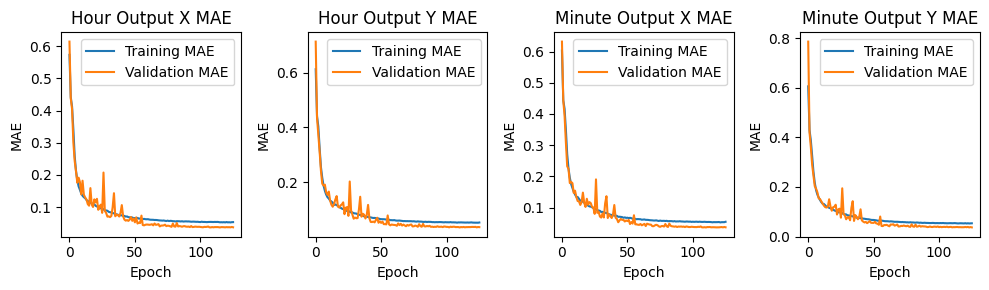

In [98]:
def plot_multi_output_regression_history(history):
    plt.figure(figsize=(10, 3))

    # # Loss
    # plt.subplot(2, 3, 1)
    # plt.plot(history.history['loss'], label='Training Loss')
    # plt.plot(history.history['val_loss'], label='Validation Loss')
    # plt.title('Total Loss (MSE)')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend(loc='best')
    
    # Hour Output X MAE
    plt.subplot(1, 4, 1)
    plt.plot(history.history['hour_output_x_mae'], label='Training MAE')
    plt.plot(history.history['val_hour_output_x_mae'], label='Validation MAE')
    plt.title('Hour Output X MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='best')

    # Hour Output Y MAE
    plt.subplot(1, 4, 2)
    plt.plot(history.history['hour_output_y_mae'], label='Training MAE')
    plt.plot(history.history['val_hour_output_y_mae'], label='Validation MAE')
    plt.title('Hour Output Y MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='best')

    # Minute Output X MAE
    plt.subplot(1,4, 3)
    plt.plot(history.history['minute_output_x_mae'], label='Training MAE')
    plt.plot(history.history['val_minute_output_x_mae'], label='Validation MAE')
    plt.title('Minute Output X MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='best')


    # Minute Output Y MAE
    plt.subplot(1, 4, 4)
    plt.plot(history.history['minute_output_y_mae'], label='Training MAE')
    plt.plot(history.history['val_minute_output_y_mae'], label='Validation MAE')
    plt.title('Minute Output Y MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend(loc='best')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig("multi_regression_loss.png") 
    plt.show()


plot_multi_output_regression_history(history_rr)

Evaluate the model

In [56]:
def calculate_common_sense_error_rr(true_hours, true_minutes,
                                    pred_hour_x, pred_hour_y,
                                    pred_minute_x, pred_minute_y,
                                    threshold=10):

    pred_hour_angle = np.degrees(np.arctan2(pred_hour_y, pred_hour_x)) % 360
    pred_minute_angle = np.degrees(np.arctan2(pred_minute_y, pred_minute_x)) % 360

    pred_hours = ((pred_hour_angle / 30) % 12).astype(int)
    pred_minutes =((pred_minute_angle / 6)).astype(int)

    true_times_in_minutes = (true_hours % 12) * 60 + true_minutes
    pred_times_in_minutes = (pred_hours % 12) * 60 + pred_minutes

    time_diffs = np.abs(pred_times_in_minutes - true_times_in_minutes)
    time_diffs = np.minimum(time_diffs, 720 - time_diffs)


    # Calculate error metrics
    mean_error = np.mean(time_diffs)
    max_error = np.max(time_diffs)
    median_error = np.median(time_diffs)
    std_dev_error = np.std(time_diffs)
    percentage_within_threshold = np.mean(time_diffs <= threshold) * 100
    percentage_within_5min = np.mean(time_diffs <= 5) * 100

    error_metrics = {
        'Mean Total Minutes Error': mean_error,
        'Max Total Minutes Error': max_error,
        'Median Total Minutes Error': median_error,
        'Standard Deviation of Total Minutes Error': std_dev_error,
        #'percentage_within_5 min': percentage_within_5min,
        f'Percentage within {threshold} minutes': percentage_within_threshold
    }

    return error_metrics

In [99]:
true_hours = y_test[:, 0]
true_minutes = y_test[:, 1]

y_pred_hour_x, y_pred_hour_y, y_pred_minute_x, y_pred_minute_y = model_mr.predict(x_test)

error_metrics = calculate_common_sense_error_rr(true_hours.reshape(-1,1),true_minutes.reshape(-1,1),
    y_pred_hour_x, y_pred_hour_y, y_pred_minute_x, y_pred_minute_y,10)


# Print results
for metric, value in error_metrics.items():
    print(f"{metric}: {value}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Total Minutes Error: 5.648333333333333
Max Total Minutes Error: 345
Median Total Minutes Error: 1.0
Standard Deviation of Total Minutes Error: 17.37650704895038
percentage_within_5 min: 91.63888888888889
Percentage within 10 minutes: 91.63888888888889


In [100]:
loss, hour_x,hour_y, minute_x, minute_y = model_mr.evaluate(x_test, [y_test_hour_x, y_test_hour_y, y_test_minute_x, y_test_minute_y])

print(f"Test Loss (MSE): {loss}")
print(f"Test HOUR X: {hour_x} Y:{hour_y}")
print(f"Test MINUTE X: {minute_x} Y:{minute_y}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - hour_output_x_mae: 0.0367 - hour_output_y_mae: 0.0364 - loss: 0.0131 - minute_output_x_mae: 0.0368 - minute_output_y_mae: 0.0392
Test Loss (MSE): 0.01272705290466547
Test HOUR X: 0.03704257681965828 Y:0.03646450117230415
Test MINUTE X: 0.03756221756339073 Y:0.039054933935403824
